In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from time import time
%matplotlib inline

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
from __future__ import division

# Attempts to find any improper values:
for c in df.columns:
    
    if df[c].loc[df[c].isnull()].count()>0:
        print "The number of null values in %s = %s" %(c,df[c].loc[df[c].isnull()].count())
        
N_transactions = df['V1'].count()
N_fraud = df['V1'].loc[df['Class']==1].count()
N_zero_transactions = df['Amount'].loc[df['Amount']==0.].count()
N_zero_fraud_transactions = df['Amount'].loc[(df['Amount']==0.) & (df['Class']==1)].count()

print "The total number of transactions = %s" % N_transactions
print "The total number of fraudulent transactions = %s" % N_fraud
print "The number of $0 transactions = %s" % N_zero_transactions
print "The number of $0 transactions which are fraudulent = %s" % N_zero_fraud_transactions

print "The fraction of all transactions that are fraudulent = %.3f%%" % (100*N_fraud/N_transactions)
print "The fraction of all 0$ transactions that are fraudulent = %.3f%%" % (100*N_zero_fraud_transactions/N_zero_transactions)

print
print "A much higher % of 0$ transactions are fraudulent, compared with the general set. This could be\
potentially interesting. However, given the very small number of fraudulent transactions, making inferences\
is questionable."

The total number of transactions = 284807
The total number of fraudulent transactions = 492
The number of $0 transactions = 1825
The number of $0 transactions which are fraudulent = 27
The fraction of all transactions that are fraudulent = 0.173%
The fraction of all 0$ transactions that are fraudulent = 1.479%

A much higher % of 0$ transactions are fraudulent, compared with the general set. This could bepotentially interesting. However, given the very small number of fraudulent transactions, making inferencesis questionable.


In [4]:
columns_no_class = list(df.columns)
columns_no_class.remove('Class')

df_clean = (df[columns_no_class]-df[columns_no_class].mean())/df[columns_no_class].std()
df_clean = pd.concat((df_clean,df['Class']),axis=1)

In [5]:
# Split the dataframe into train and test sets
# Do so in a manner which preserves the proportion of classes (so as not to bias the set)
# First, split the class=0 indices
C_0_train_index, C_0_test_index = train_test_split(df_clean.loc[df['Class']==0].index.values)
# First, split the class=1 indices
C_1_train_index, C_1_test_index = train_test_split(df_clean.loc[df['Class']==1].index.values)
# Copy the data frames into a train and test version, based on the obtained indices
df_train = df_clean.loc[np.concatenate((C_0_train_index,C_1_train_index))]
df_test = df_clean.loc[np.concatenate((C_0_test_index,C_1_test_index))]

df_train_X = df_train[columns_no_class]
df_train_Y = df_train['Class']
df_test_X = df_test[columns_no_class]
df_test_Y = df_test['Class']

In [34]:
def model_selection(algorithm,train_X):
    
    KNN_params = {'n_neighbors':range(1,51),'weights':['uniform','distance'],'algorithm':['ball_tree','kd_tree'],
             'leaf_size':range(15,46),'n_jobs':[-1]}
    
    random_forest_params = {'n_estimators':range(1,51),'criterion':['gini','entropy'],
                            'max_features':np.linspace(1./float(train_X.shape[1]),1.,50),'max_depth':range(1,51),
                            'class_weight':[None],'n_jobs':[-1]}
    
    logistic_regression_params = {'tol':10.**(np.linspace(-6,-2,10)),'C':10.**np.linspace(-3,1,10),
                                 'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag'],'n_jobs':[-1]}
    
    param_dicts = {'knn':KNN_params,'random_forest':random_forest_params,'log_reg':logistic_regression_params}
    
    algorithm_dict = {'knn':KNeighborsClassifier(),'random_forest':RandomForestClassifier(),
                      'log_reg':LogisticRegression()}
    
    return algorithm_dict[algorithm], param_dicts[algorithm]    

In [31]:
def optimize_hyperparameters(algorithm,train_X,train_Y):
    
    algo, params = model_selection(algorithm,train_X)

    grid_search = RandomizedSearchCV(algo,param_distributions=params,n_iter=10,scoring='recall',cv=2,error_score=0.)

    grid_search.fit(train_X,train_Y)
    
    print "The results for %s:" %algorithm
    print "The hyperparameters which give the highest recall:"
    print grid_search.best_params_
    print
    print "The best score = %s" %grid_search.best_score_
    
    np.save('%s_optimized_hyperparams.npy'%algorithm,grid_search.best_params_)

In [32]:
def train_and_validate(algorithm,train_X,train_Y,test_X,test_Y,optimized_params):
    
    algo = model_selection(algorithm,train_X)[0]
    
    try:
        
        clf = algo.set_params(**optimized_params)
        clf.fit(train_X,train_Y)
        Y_pred = clf.predict(test_X)

    except KeyError:
        
        print "KeyError: algorithm selected has not been set up."
        
    print "The precision using the best params = %s" % precision_score(test_Y,Y_pred)
    print
    print "The recall using the best params = %s" % recall_score(test_Y,Y_pred)

In [8]:
def precision_times_recall(estimator,x_test,y_test,c=1):
    
    Y_pred = estimator.predict(x_test)
    
    precision = precision_score(y_test,Y_pred)
    recall = recall_score(y_test,Y_pred)
    
    return precision*recall

In [33]:
if __name__ == '__main__':
    
    pca = PCA(n_components=10)
    pca_train_X = pca.fit_transform(df_train_X,df_train_Y)
    pca_test_X = pca.transform(df_test_X)
    
# Choose algorithm from ['random_forest', 'knn', 'log_reg']
    algorithm = 'log_reg'
    
    algo, params = model_selection(algorithm,pca_train_X)
    
    param = 'solver'
    for i in params[param]:
        
        start = time()
        
        clf = algo.set_params(**{param:i})
        clf.fit(pca_train_X,df_train_Y)
        Y_pred = clf.predict(pca_test_X)
        
        print "Recall for %s = %s = %s" %(param,i,recall_score(df_test_Y,Y_pred))
        print "Amount of time to run = %s" %(time()-start)
        print
        
    
    algorithm = 'random_forest'
    
    try:
        
        optimized_params = np.load('%s_optimized_hyperparams.npy'%algorithm).item()
        print
        print "Optimized hyperparameters for %s loaded successfully:" %algorithm
        print optimized_params
        
    except:
        
        print
        print "Need to obtain optimized hyperparameters for %s." %algorithm
        optimize_hyperparameters(algorithm,pca_train_X,df_train_Y)
        optimized_params = np.load('%s_optimized_hyperparams.npy'%algorithm).item()
        
    train_and_validate(algorithm,pca_train_X,df_train_Y,pca_test_X,df_test_Y,optimized_params)

Recall for solver = newton-cg = 0.487804878049
Amount of time to run = 0.987292051315

Recall for solver = lbfgs = 0.487804878049
Amount of time to run = 0.406782865524

Recall for solver = liblinear = 0.487804878049
Amount of time to run = 0.599906921387

Recall for solver = sag = 0.479674796748
Amount of time to run = 9.86556696892


Optimized hyperparameters for random_forest loaded successfully:
{'n_jobs': -1, 'n_estimators': 14, 'criterion': 'gini', 'max_features': 0.66938775510204085, 'max_depth': 7, 'class_weight': None}
The precision using the best params = 0.906542056075

The recall using the best params = 0.788617886179


In [16]:
# Test the effect of n_estimators on precision and recall
precision = []
recall = []
for i in range(1,31):
    clf = RandomForestClassifier(n_estimators=i,criterion='entropy',max_features='auto',
                                 class_weight={0:float(len(df_train_Y[df_train_Y==0]))/float(len(df_train_Y)),
                                              1:float(len(df_train_Y[df_train_Y==1]))/float(len(df_train_Y))})
    clf.fit(df_train_X,df_train_Y)
    Y_pred = clf.predict(df_test_X)

    P_R = precision_recall(df_test_Y,Y_pred,0)
    
    precision.append(P_R[0])
    recall.append(P_R[1])
    
    print "Run with %s trees is done." %i
    
#    print "Number of trees = %s" %i
#    print "The precision = %s" %precision
#    print "The recall = %s" %recall
#    print "The score with %s trees = %s" %(i,clf.score(df_test_X,df_test_Y))

Run with 1 trees is done.
Run with 2 trees is done.
Run with 3 trees is done.
Run with 4 trees is done.
Run with 5 trees is done.
Run with 6 trees is done.
Run with 7 trees is done.
Run with 8 trees is done.
Run with 9 trees is done.
Run with 10 trees is done.
Run with 11 trees is done.
Run with 12 trees is done.
Run with 13 trees is done.
Run with 14 trees is done.
Run with 15 trees is done.
Run with 16 trees is done.
Run with 17 trees is done.
Run with 18 trees is done.
Run with 19 trees is done.
Run with 20 trees is done.
Run with 21 trees is done.
Run with 22 trees is done.
Run with 23 trees is done.
Run with 24 trees is done.
Run with 25 trees is done.
Run with 26 trees is done.
Run with 27 trees is done.
Run with 28 trees is done.
Run with 29 trees is done.
Run with 30 trees is done.


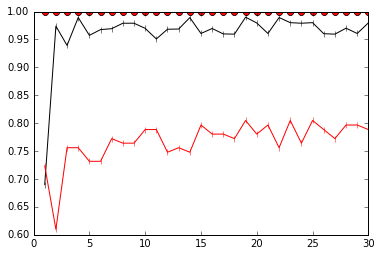

In [14]:
plt.plot(range(1,31),precision[0],marker='o',color='k')
plt.plot(range(1,31),recall[0],marker='o',color='r')

plt.plot(range(1,31),precision[1],marker='|',color='k')
plt.plot(range(1,31),recall[1],marker='|',color='r')

plt.show()

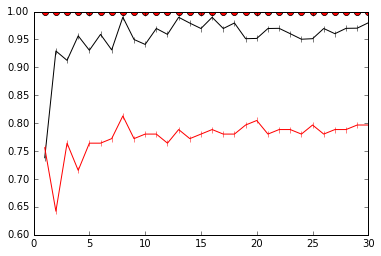

In [17]:
plt.plot(range(1,31),precision[0],marker='o',color='k')
plt.plot(range(1,31),recall[0],marker='o',color='r')

plt.plot(range(1,31),precision[1],marker='|',color='k')
plt.plot(range(1,31),recall[1],marker='|',color='r')

plt.show()

In [28]:
# Perform a randomized grid search for the hyperparameters which result in the highest recall,
# using RandomForestClassifier
random_forest_params = dict(zip(['n_estimators','criterion','max_features','max_depth','class_weight','n_jobs'],
                               [range(1,51),['gini','entropy'],np.linspace(1./float(df_train_X.shape[1]),1.,50),
                                range(1,51),[None,{0:float(len(df_train_Y[df_train_Y==0]))/float(len(df_train_Y)),
                                              1:float(len(df_train_Y[df_train_Y==1]))/float(len(df_train_Y))},
                                            {1:float(len(df_train_Y[df_train_Y==0]))/float(len(df_train_Y)),
                                              0:float(len(df_train_Y[df_train_Y==1]))/float(len(df_train_Y))}],[-1]]))

grid_search = RandomizedSearchCV(RandomForestClassifier(),param_distributions=random_forest_params,n_iter=100,
                                scoring='recall',cv=2)

grid_search.fit(df_train_X,df_train_Y)

print "The hyperparameters which give the highest recall:"
print grid_search.best_params_
print
print "The best score chosen:"
print grid_search.best_score_


The hyperparameters which give the highest recall:
{'n_jobs': -1, 'n_estimators': 26, 'criterion': 'gini', 'max_features': 0.30952380952380953, 'max_depth': 3, 'class_weight': {0: 0.0017274876524425926, 1: 0.9982725123475574}}

The best estimator chosen:
RandomForestClassifier(bootstrap=True,
            class_weight={0: 0.0017274876524425926, 1: 0.9982725123475574},
            criterion='gini', max_depth=3,
            max_features=0.30952380952380953, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=26, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

The best score chosen:
0.864526977997


In [38]:
# Perform a randomized grid search for the hyperparameters which result in the highest recall*precision,
# using RandomForestClassifier
random_forest_params = dict(zip(['n_estimators','criterion','max_features','max_depth','class_weight','n_jobs'],
                               [range(1,51),['gini','entropy'],np.linspace(1./float(df_train_X.shape[1]),1.,50),
                                range(1,51),[None],[-1]]))

grid_search = RandomizedSearchCV(RandomForestClassifier(),param_distributions=random_forest_params,n_iter=100,
                                scoring=precision_times_recall,cv=2)

grid_search.fit(df_train_X,df_train_Y)

print "The hyperparameters which give the highest recall:"
print grid_search.best_params_
print
print "The best score chosen:"
print grid_search.best_score_

clf = RandomForestClassifier().set_params(**grid_search.best_params_)
clf.fit(df_train_X,df_train_Y)
Y_pred = clf.predict(df_test_X)

print
print "The precision using the best params = %s" % precision_score(df_test_Y,Y_pred)
print
print "The recall using the best params = %s" % recall_score(df_test_Y,Y_pred)

The hyperparameters which give the highest recall:
{'n_jobs': -1, 'n_estimators': 35, 'criterion': 'gini', 'max_features': 0.54625850340136062, 'max_depth': 27, 'class_weight': None}

The best score chosen:
0.723893444109

The precision using the best params = 0.95145631068

The recall using the best params = 0.79674796748


In [46]:
knn = KNeighborsClassifier()
knn.fit(df_train_X,df_train_Y)
Y_pred = knn.predict(df_test_X)

print "Precision = %s" % precision_score(df_test_Y,Y_pred)
print
print "Recall = %s" % recall_score(df_test_Y,Y_pred)

Precision = 0.95

Recall = 0.772357723577
IT took 752.680958986 seconds


In [48]:
pca = PCA(n_components=10)

knn_train_X = pca.fit_transform(df_train_X,df_train_Y)

knn_test_X = pca.transform(df_test_X)

knn = KNeighborsClassifier()
knn.fit(knn_train_X,df_train_Y)
Y_pred = knn.predict(knn_test_X)

print "Precision = %s" % precision_score(df_test_Y,Y_pred)
print
print "Recall = %s" % recall_score(df_test_Y,Y_pred)



Precision = 0.958762886598

Recall = 0.756097560976
IT took 55.0104951859 seconds


In [ ]:
KNN_params = {'n_neighbors':range(1,51),'weights':['uniform','distance'],'algorithm':['ball_tree','kd_tree'],
             'leaf_size':range(15,46),'n_jobs':[-1]}

pca = PCA(n_components=10)
knn_train_X = pca.fit_transform(df_train_X,df_train_Y)
knn_test_X = pca.transform(df_test_X)

grid_search = RandomizedSearchCV(KNeighborsClassifier(),param_distributions=KNN_params,n_iter=100,
                                 scoring=precision_times_recall,cv=2)

grid_search.fit(knn_train_X,df_train_Y)

print "The hyperparameters which give the highest recall:"
print grid_search.best_params_
print
print "The best score = %s" %grid_search.best_score_

clf = KNeighborsClassifier().set_params(**grid_search.best_params_)
clf.fit(knn_train_X,df_train_Y)
Y_pred = clf.predict(knn_test_X)

print
print "The precision using the best params = %s" % precision_score(df_test_Y,Y_pred)
print
print "The recall using the best params = %s" % recall_score(df_test_Y,Y_pred)


Need to obtain optimized hyperparameters for log_reg.


/Users/yevgenikissin/anaconda/lib/python2.7/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [52]:

knn_train_X = df_train_X[df_train_X.columns[1:12]].copy()
knn_test_X = df_test_X[df_train_X.columns[1:12]].copy()

start = time()

knn = KNeighborsClassifier()
knn.fit(knn_train_X,df_train_Y)
Y_pred = knn.predict(knn_test_X)

print "Precision = %s" % precision_score(df_test_Y,Y_pred)
print
print "Recall = %s" % recall_score(df_test_Y,Y_pred)

print "IT took %s seconds" %(time()-start) 

Precision = 0.947916666667

Recall = 0.739837398374
IT took 31.4692268372 seconds


In [122]:
clf = RandomForestClassifier(n_estimators=10,criterion='entropy',max_features='auto')
clf.fit(df_train_X,df_train_Y)
Y_pred = clf.predict(df_test_X)

precision_recall(df_test_Y,Y_pred,1)

feature_importance = zip(df_train.columns,clf.feature_importances_)
feature_importance = sorted(feature_importance,key=lambda x: x[1], reverse=True)
feature_names = zip(*feature_importance)[0]
print "The 3 dominant features are = %s, %s, and %s" %(feature_names[0],feature_names[1],feature_names[2])

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [25]:
clf = RandomForestClassifier(n_estimators=5,criterion='entropy',max_features='auto',
                                 class_weight={0:float(len(df_train_Y[df_train_Y==0]))/float(len(df_train_Y)),
                                              1:float(len(df_train_Y[df_train_Y==1]))/float(len(df_train_Y))})
clf.fit(df_train_X,df_train_Y)
Y_pred = clf.predict(df_test_X)

P_R = precision_recall(df_test_Y,Y_pred,1)

print "The precision according to my calculation = %s" %P_R[0]
print "The recall according to my calculation = %s" %P_R[1]
print
print "The precision according to sklearn calculation = %s" % precision_score(df_test_Y,Y_pred)
print "The recall according to sklearn calculation = %s" %recall_score(df_test_Y,Y_pred)

The precision according to my calculation = 0.948453608247
The recall according to my calculation = 0.747967479675

The precision according to sklearn calculation = 0.948453608247
The recall according to sklearn calculation = 0.747967479675
The precision according to my calculation = 0.949494949495
The recall according to my calculation = 0.764227642276

The precision according to sklearn calculation = 0.949494949495
The recall according to sklearn calculation = 0.764227642276
The precision according to my calculation = 0.967741935484
The recall according to my calculation = 0.731707317073

The precision according to sklearn calculation = 0.967741935484
The recall according to sklearn calculation = 0.731707317073


0.999508440774
0.998398921379


In [19]:
clf_bayes = GaussianNB()
clf_bayes.fit(df_train_X,df_train_Y)
Y_pred = clf_bayes.predict(df_test_X)

P_R = precision_recall(df_test_Y,Y_pred,1)

print "Naive Bayes:"
print "The precision = %s" % P_R[0]
print "The recall = %s" % P_R[1]

prior = [float(len(df_train_Y[df_train_Y==0]))/float(len(df_train_Y)),
         float(len(df_train_Y[df_train_Y==1]))/float(len(df_train_Y))]

clf_bayes = GaussianNB(prior)
clf_bayes.fit(df_train_X,df_train_Y)
Y_pred = clf_bayes.predict(df_test_X)

P_R = precision_recall(df_test_Y,Y_pred,1)

print "Naive Bayes:"
print "The precision = %s" % P_R[0]
print "The recall = %s" % P_R[1]

print "The number of predicted fraud cases = %s" % len(Y_pred[Y_pred==1])
print "The number of actual fraud cases = %s" % len(df_test_Y[df_test_Y==1])

Naive Bayes:
The precision = 0.0637645616186
The recall = 0.845528455285
Naive Bayes:
The precision = 0.0637645616186
The recall = 0.845528455285
The number of predicted fraud cases = 1631
The number of actual fraud cases = 123


[('V17', 0.16995329574024545), ('V11', 0.1270129304294387), ('V14', 0.12409809809914432), ('V10', 0.12046467782453725), ('V12', 0.084706073904392526), ('V4', 0.074360756466227335), ('V7', 0.04078441260086433), ('V3', 0.025478560126986859), ('V2', 0.023805335802521557), ('V16', 0.017455024156609988), ('V1', 0.017234412866801448), ('V18', 0.015157055972968566), ('V26', 0.011984614118157993), ('V19', 0.011610333006659816), ('V6', 0.011155835620898662), ('V8', 0.011100711602187506), ('Amount', 0.011009727909587938), ('V20', 0.010922177040988456), ('V27', 0.010245667175239415), ('V9', 0.0097621538300886705), ('V28', 0.0094958023285274338), ('V15', 0.0090106492053403306), ('V21', 0.0088768340149149531), ('Time', 0.0078011102741095562), ('V22', 0.0077289083829639362), ('V5', 0.0073153029627284882), ('V24', 0.0060454794371867559), ('V23', 0.0052670661607764294), ('V13', 0.005194553586498632), ('V25', 0.0049624393524066758)]


[('V17', 0.16995329574024545), ('V11', 0.1270129304294387), ('V14', 

In [156]:
def P_times_R_slow_version(estimator,x_test,y_test,c=1):
    
    Y_pred = estimator.predict(x_test)
    
    true_pos = 0.
    false_pos = 0.
    true_neg = 0.
    false_neg = 0.
    
    y_test = np.asarray(y_test)
    
    for i in range(y_test.shape[0]):
        
        if (y_test[i]==c and Y_pred[i]==c):
            true_pos += 1.
        elif (y_test[i]==c and Y_pred[i]!=c):
            false_neg += 1.
        elif (y_test[i]!=c and Y_pred[i]==c):
            false_pos += 1.
        elif (y_test[i]!=c and Y_pred[i]!=c):
            true_neg += 1.


    #print "Total number of samples = %s" %y_test.shape
    #print "Total number of true_pos = %s" %true_pos
    #print "Total number of false_pos = %s" %false_pos
    #print "Total number of true_neg = %s" %true_neg
    #print "Total number of false_neg = %s" %false_neg

    
    #print "Precision = %s" % (true_pos/(false_pos+true_pos))
    #print "Recall = %s" % (true_pos/(false_neg+true_pos))
    
    return true_pos**2./((false_neg+true_pos)*(false_pos+true_pos))
